In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import seaborn as sns
import scipy as sp
import scipy.stats
import os
import matplotlib as mpl
# 시각화에서 한글 설정
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)

# 시각화에서 음수 표현 설정
plt.rcParams['axes.unicode_minus'] = False 

# Jupyter Notebook 출력 소수점 이하 3자리로 제한
%precision 3
pd.options.display.precision = 3

# 이미지 저장 경로 설정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 시각화 설정
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 음수 부호 표시 오류 제어
mpl.rcParams['axes.unicode_minus'] = False

# Seaborn 및 Scipy 임포트
import seaborn as sns
import scipy as sp
from scipy import stats

# 사이킷런 버전 확인 및 설정
import sklearn
assert sklearn.__version__ >= "0.20"

# 결과 재현을 위한 난수 시드 설정
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우
# 시드가 변경이 되어 훈련용 데이터가 자주 변경된다면
# 결국 모든 데이터를 가지고 모델을 생성하는 결과를 초래함
# Overfitting 문제 발생
np.random.seed(42)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml

## Kaggle 다시 한번

In [3]:
import pandas as pd
data_path='./data/cfec/'
train=pd.read_csv(data_path+'train.csv',index_col='id')
test=pd.read_csv(data_path+'test.csv',index_col='id')
submission=pd.read_csv(data_path+'sample_submission.csv',index_col='id')

In [4]:
# 데이터 탐색
print(train.shape)
print(test.shape)
print(train.head())
# 답안은 어떻게 제출해?
print(submission.head())
# 0.5로 나오는 것을 보니 확률이구나

(300000, 24)
(200000, 23)
    bin_0  bin_1  bin_2 bin_3 bin_4  nom_0      nom_1    nom_2    nom_3  \
id                                                                        
0       0      0      0     T     Y  Green   Triangle    Snake  Finland   
1       0      1      0     T     Y  Green  Trapezoid  Hamster   Russia   
2       0      0      0     F     Y   Blue  Trapezoid     Lion   Russia   
3       0      1      0     F     Y    Red  Trapezoid    Snake   Canada   
4       0      0      0     F     N    Red  Trapezoid     Lion   Canada   

       nom_4  ...      nom_9 ord_0        ord_1        ord_2 ord_3  ord_4  \
id            ...                                                           
0    Bassoon  ...  2f4cb3d51     2  Grandmaster         Cold     h      D   
1      Piano  ...  f83c56c21     1  Grandmaster          Hot     a      A   
2   Theremin  ...  ae6800dd0     1       Expert     Lava Hot     h      R   
3       Oboe  ...  8270f0d71     1  Grandmaster  Boiling Hot   

In [5]:
# feature의 정보를 요약해주는 함수
def resumetable(df):
    print('데이터의 구조 :',df.shape)
    summary=pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary=summary.reset_index()
    summary=summary.rename(columns={'index':'Feature'})
    summary['결측값 개수']=df.isnull().sum().values
    summary['고유값 개수']=df.nunique().values
    summary['첫 번째 값']=df.loc[0].values
    summary['두 번째 값']=df.loc[1].values
    summary['세 번째 값']=df.loc[2].values
    return summary
resumetable(train)

데이터의 구조 : (300000, 24)


,Feature,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [6]:
# 순서형 feature 목록 확인
for i in range(3):
    feature='ord_'+str(i)
    print(feature+' 고유 값 : ',train[feature].unique())

ord_0 고유 값 :  [2 1 3]
ord_1 고유 값 :  ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고유 값 :  ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


In [7]:
# 순서형 feature 목록 확인
for i in range(3,6):
    feature='ord_'+str(i)
    print(feature+' 고유 값 : ',train[feature].unique())

ord_3 고유 값 :  ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고유 값 :  ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고유 값 :  ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'dZ' 'yN' 'Nf' 'QM' 'jV' 'sY' 'wu' 'SB'
 'UO' 'Mx' 'JX' 'Ry' 'Uk' 'uJ' 'LE' 'ps' 'kE' 'MO' 'kw' 'yY' 'zU' 'bJ'
 'Kf' 'c

In [8]:
print('day 고유값 : ', train['day'].unique())
print('month 고유값 : ', train['month'].unique())
print('target 고유값 : ', train['target'].unique())

day 고유값 :  [2 7 5 4 3 1 6]
month 고유값 :  [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고유값 :  [0 1]


[Text(0.5, 1.0, 'target data distribution')]

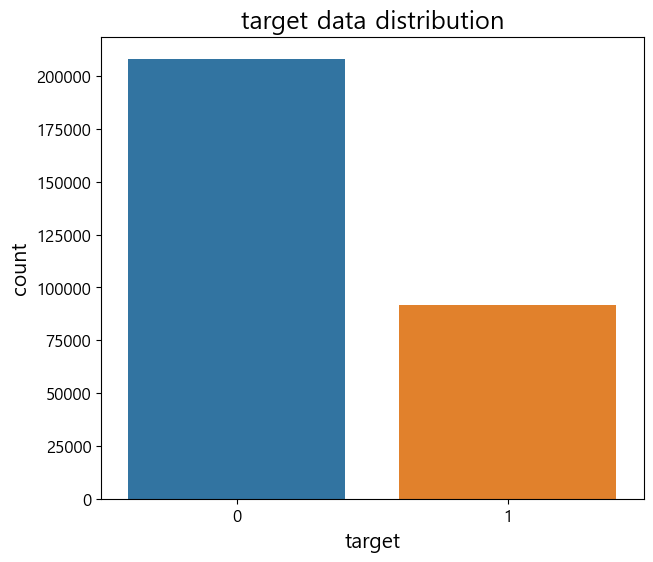

In [9]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',size=15)
plt.figure(figsize=(7,6))
# target의 분포 확인하기
ax=sns.countplot(x='target', data=train)
ax.set(title='target data distribution')
# 0 : 1 = 2 :1 비율이에요

In [10]:
# 첫 번쨰 막대에 대한 정보를 확인
rectangle=ax.patches[0]
print('높이 :', rectangle.get_height())
print('너비 :', rectangle.get_width())
# 왼쪽 테두리의 x좌표가 중요해
print('왼쪽 테두리의 x좌표 : ', rectangle.get_x())

높이 : 208236.0
너비 : 0.8
왼쪽 테두리의 x좌표 :  -0.4


Text(0.5, 1.0, 'Target Distribution')

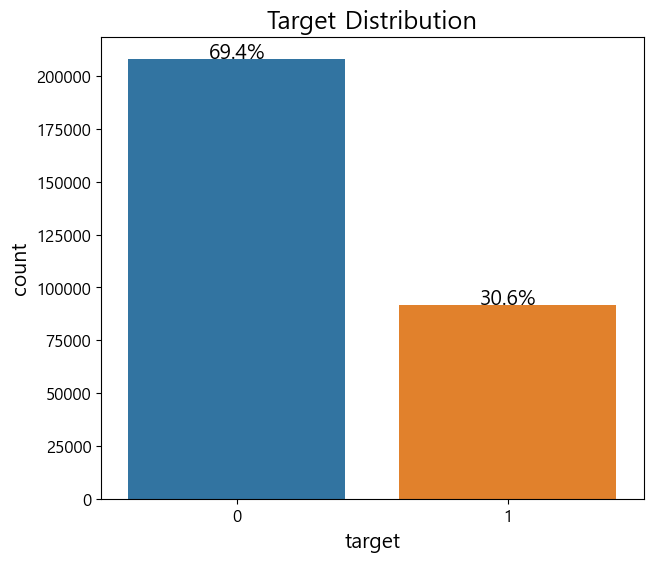

In [11]:
# 텍스트 출력 - 비율을 표시하자
def write_percent(ax,total_size):
    for patch in ax.patches:
        height=patch.get_height()
        width=patch.get_width()
        left_coord=patch.get_x()
        #막대의 높이를 이용해서 비율 구하기
        percent=height/total_size*100
        #텍스트 출력
        ax.text(x=left_coord+width/2.0,
               y=height+total_size*0.001,
               s=f'{percent:1.1f}%',
                ha='center')
plt.figure(figsize=(7,6))
ax=sns.countplot(x='target',data=train)
write_percent(ax,len(train))
ax.set_title("Target Distribution")

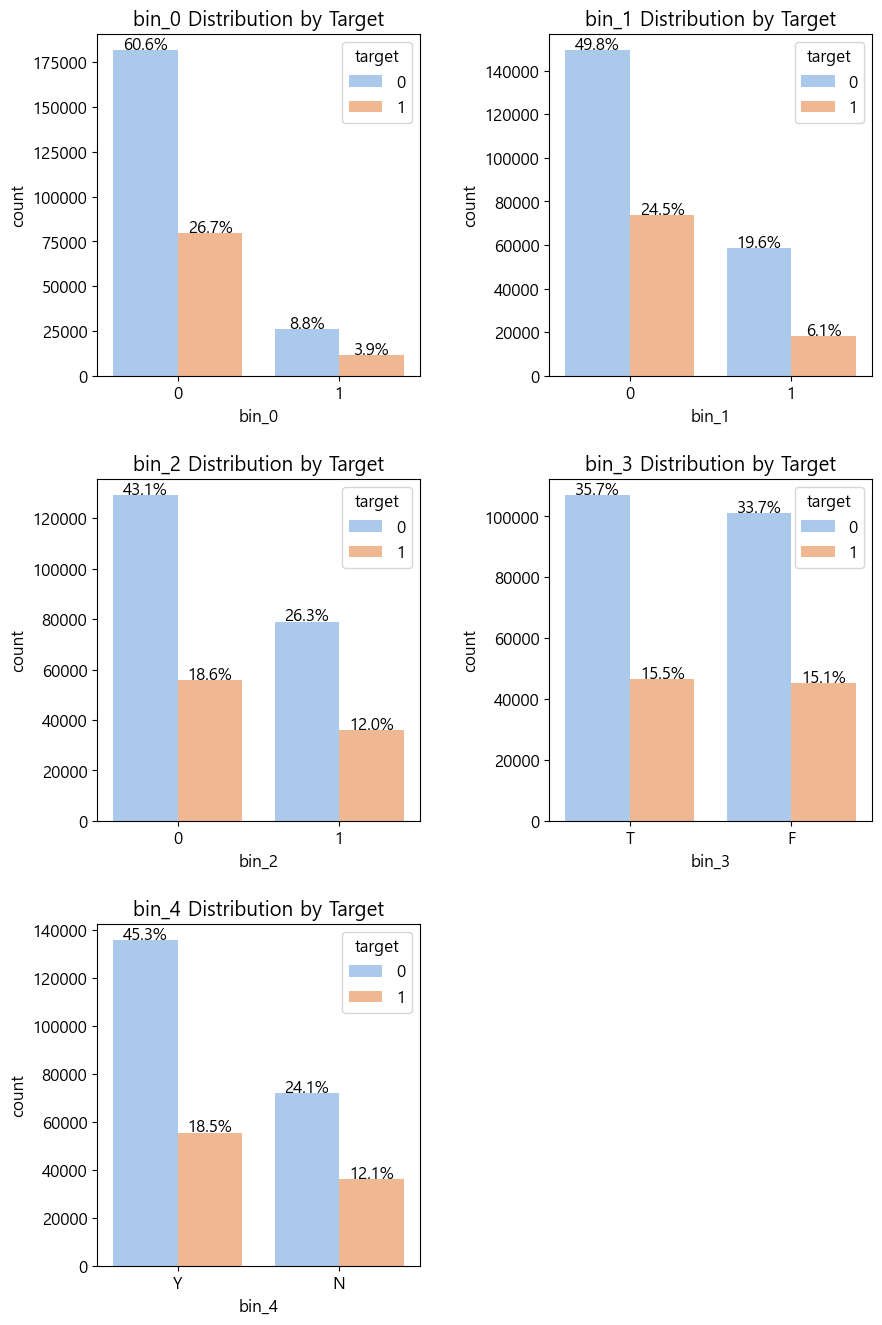

In [12]:
# 여러 개의 이진 데이터 분포를 확인해보자.
# 여러 개의 이미지를 출력할 때 사용하는 격자
import matplotlib.gridspec as gridspec
mpl.rc('font',size=12)
grid=gridspec.GridSpec(3,2)#행,열
plt.figure(figsize=(10,16))
plt.subplots_adjust(wspace=0.4,hspace=0.3)
# 시각화할 컬럼 리스트
bin_features=['bin_0','bin_1','bin_2','bin_3','bin_4']
for idx,feature in enumerate(bin_features):
    ax=plt.subplot(grid[idx])
    sns.countplot(x=feature,data=train,hue='target',palette='pastel',ax=ax)
    ax.set_title(f'{feature} Distribution by Target')
    write_percent(ax,len(train))

In [13]:
pd.crosstab(train['nom_0'],train['target'])
# 백분율로 보고싶다면?
cross=pd.crosstab(train['nom_0'],train['target'], normalize='index')*100
# 인덱스 좀 보기 싫으면 이렇게 밀자
cross=cross.reset_index()
# cross
# 이것도 함수로 만들면 편하지 않을까?
def get_crosstab(df,feature):
    crosstab=pd.crosstab(df[feature],df['target'],normalize='index')*100
    crosstab=crosstab.reset_index()
    return crosstab
crosstab=get_crosstab(train, 'nom_1')
crosstab

target,nom_1,0,1
0,Circle,75.434,24.566
1,Polygon,68.453,31.547
2,Square,66.107,33.893
3,Star,68.937,31.063
4,Trapezoid,70.995,29.005
5,Triangle,63.902,36.098


In [14]:
# print(train['ord_1'])
# 순서가 있다면, 순서대로 만들어줘야 한다.
# train['ord_1'].unique()
# ord_1는 Novice, Contributor, Expert, Master, Grandmaster 순서
# ord_2는 Freezing, Cold, Warm, Hot, Boiling Hot, Lava Hot 순서
from pandas.api.types import CategoricalDtype
ord_1_value=['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value=['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
# 문자열 리스트를 type으로 생성 -enum 
ord_1_dtype=CategoricalDtype(categories=ord_1_value,ordered=True)
ord_2_dtype=CategoricalDtype(categories=ord_2_value,ordered=True)
train['ord_1']=train['ord_1'].astype(ord_1_dtype)
train['ord_2']=train['ord_2'].astype(ord_2_dtype)

## 제출용

In [32]:
# 데이터 오염 문제로 다시 데이터를 가져오자.
data_path='./data/cfec/'
train=pd.read_csv(data_path+'train.csv',index_col='id')
test=pd.read_csv(data_path+'test.csv',index_col='id')
submission=pd.read_csv(data_path+'sample_submission.csv',index_col='id')

In [33]:
## 훈련 데이터와 테스트 데이터를 합쳐야 합니다. (전처리 전)
all_data=pd.concat([train,test])
# target은 전처리 대상이 아닙니다.
all_data=all_data.drop('target',axis=1)
# all_data.head()

In [34]:
# 범주형 데이터를 원핫인코딩
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
all_data_encoded=encoder.fit_transform(all_data)
# fit_transform하면 ndarray로 나와요
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8


In [35]:
# 훈련 / 테스트 분리
num_train=len(train)
X_train=all_data_encoded[:num_train]
X_test=all_data_encoded[num_train:]
y=train['target']

In [19]:
# 여기 잠깐 넘겨보자

# 훈련에 사용할 데이터와 검증을 위한 데이터 분리
from sklearn.model_selection import train_test_split
# 2:1 target 차이 많이 나이게 층화 추출로
# 테스트 데이터와 검증용 데이터 생성하기
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y,
                                                test_size=0.1,
                                                random_state=42,
                                                stratify=y)

## modeling

In [20]:
# # 이진 분류 이므로 모든 분류기 사용 가능
# from sklearn.linear_model import LogisticRegression
# # 모델 만들기
# logistic_model=LogisticRegression(max_iter=1000,random_state=42)
# # 훈련
# logistic_model.fit(X_train,y_train)

# valid 분리 x 버전
# 이진 분류 이므로 모든 분류기 사용 가능
from sklearn.linear_model import LogisticRegression
# 모델 만들기
logistic_model=LogisticRegression(max_iter=1000,random_state=42)
# 훈련
logistic_model.fit(X_train,y)

LogisticRegression(max_iter=1000, random_state=42)

In [21]:
# # 예측
# y_valid_pred=logistic_model.predict(X_valid)
# # 예측 확률
# y_valid_preds=logistic_model.predict_proba(X_valid)
# valid 분리 x

In [22]:
# # 평가지표 - ROC AUC : pred_proba가 필요하다
# y_valid_preds=logistic_model.predict_proba(X_valid)[:,1]
# from sklearn.metrics import roc_auc_score
# roc_auc=roc_auc_score(y_valid, y_valid_preds)
# print("평가 점수 : ", roc_auc)
# valid 분리 x

평가 점수 :  0.7949742094746153


In [36]:
# 문자로 된 경우, 숫자로 수정하는 것이 매우 좋습니다.
all_data['bin_3']=all_data['bin_3'].map({'F':0,'T':1})
all_data['bin_4']=all_data['bin_4'].map({'N':0,'Y':1})

In [37]:
# print(all_data.head())
# ord_1, ord_2,... 다 문자다 순서는 지켜주는게 좋다. 
ord1dict={'Novice':0,'Contributor':1,'Expert':2,'Master':3,'Grandmaster':4}
ord2dict={'Freezing':0,'Cold':1,'Warm':2,'Hot':3,'Boiling Hot':4,'Lava Hot':5}
all_data['ord_1']=all_data['ord_1'].map(ord1dict)
all_data['ord_2']=all_data['ord_2'].map(ord2dict)
print(all_data.head())

    bin_0  bin_1  bin_2  bin_3  bin_4  nom_0      nom_1    nom_2    nom_3  \
id                                                                          
0       0      0      0      1      1  Green   Triangle    Snake  Finland   
1       0      1      0      1      1  Green  Trapezoid  Hamster   Russia   
2       0      0      0      0      1   Blue  Trapezoid     Lion   Russia   
3       0      1      0      0      1    Red  Trapezoid    Snake   Canada   
4       0      0      0      0      0    Red  Trapezoid     Lion   Canada   

       nom_4  ...      nom_8      nom_9 ord_0 ord_1 ord_2  ord_3  ord_4  \
id            ...                                                         
0    Bassoon  ...  c389000ab  2f4cb3d51     2     4     1      h      D   
1      Piano  ...  4cd920251  f83c56c21     1     4     3      a      A   
2   Theremin  ...  de9c9f684  ae6800dd0     1     2     5      h      R   
3       Oboe  ...  4ade6ab69  8270f0d71     1     4     4      i      D   
4       Ob

In [38]:
# ord_3, ord_4, ord_5는 순서가 있는 범주형
# One Hot이 아닌 Ordinal Encoding 수행
# 명확한 순서를 모른다면 그냥 OrdinalEncoder 해주면 된다.
from sklearn.preprocessing import OrdinalEncoder
ord_345=['ord_3','ord_4','ord_5']
ord_encoder=OrdinalEncoder()
all_data[ord_345]=ord_encoder.fit_transform(all_data[ord_345])
for feature, categories in zip(ord_345,ord_encoder.categories_):
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

In [39]:
nom_features=['nom_'+str(i) for i in range(10)]
from sklearn.preprocessing import OneHotEncoder
onehot_encoder=OneHotEncoder()
encoded_nom_matrix=onehot_encoder.fit_transform(all_data[nom_features])
all_data=all_data.drop(nom_features,axis=1)
print(all_data.head())

    bin_0  bin_1  bin_2  bin_3  bin_4  ord_0  ord_1  ord_2  ord_3  ord_4  \
id                                                                         
0       0      0      0      1      1      2      4      1    7.0    3.0   
1       0      1      0      1      1      1      4      3    0.0    0.0   
2       0      0      0      0      1      1      2      5    7.0   17.0   
3       0      1      0      0      1      1      4      4    8.0    3.0   
4       0      0      0      0      0      1      4      0    0.0   17.0   

    ord_5  day  month  
id                     
0   136.0    2      2  
1    93.0    7      8  
2    31.0    7      2  
3   134.0    2      1  
4   158.0    7      8  


In [40]:
date_features=['day','month']
encoded_date_matrix=onehot_encoder.fit_transform(all_data[date_features])
all_data=all_data.drop(date_features, axis=1)
print(encoded_date_matrix)

  (0, 1)	1.0
  (0, 8)	1.0
  (1, 6)	1.0
  (1, 14)	1.0
  (2, 6)	1.0
  (2, 8)	1.0
  (3, 1)	1.0
  (3, 7)	1.0
  (4, 6)	1.0
  (4, 14)	1.0
  (5, 1)	1.0
  (5, 8)	1.0
  (6, 4)	1.0
  (6, 10)	1.0
  (7, 3)	1.0
  (7, 8)	1.0
  (8, 2)	1.0
  (8, 10)	1.0
  (9, 2)	1.0
  (9, 8)	1.0
  (10, 2)	1.0
  (10, 16)	1.0
  (11, 6)	1.0
  (11, 8)	1.0
  (12, 2)	1.0
  :	:
  (499987, 9)	1.0
  (499988, 0)	1.0
  (499988, 16)	1.0
  (499989, 2)	1.0
  (499989, 9)	1.0
  (499990, 1)	1.0
  (499990, 14)	1.0
  (499991, 1)	1.0
  (499991, 13)	1.0
  (499992, 3)	1.0
  (499992, 16)	1.0
  (499993, 1)	1.0
  (499993, 14)	1.0
  (499994, 3)	1.0
  (499994, 7)	1.0
  (499995, 0)	1.0
  (499995, 9)	1.0
  (499996, 1)	1.0
  (499996, 8)	1.0
  (499997, 2)	1.0
  (499997, 7)	1.0
  (499998, 1)	1.0
  (499998, 7)	1.0
  (499999, 1)	1.0
  (499999, 8)	1.0


In [41]:
from sklearn.preprocessing import MinMaxScaler
ord_features=['ord_'+str(i) for i in range(6)]
all_data[ord_features]=MinMaxScaler().fit_transform(all_data[ord_features])
all_data[ord_features]

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,
0,0.5,1.00,0.2,0.500,0.12,0.712
1,0.0,1.00,0.6,0.000,0.00,0.487
2,0.0,0.50,1.0,0.500,0.68,0.162
3,0.0,1.00,0.8,0.571,0.12,0.702
4,0.0,1.00,0.0,0.000,0.68,0.827
...,...,...,...,...,...,...
499995,0.0,0.00,1.0,0.643,0.00,0.131
499996,0.0,0.25,1.0,0.357,0.72,0.089
499997,0.0,0.00,0.8,0.429,0.84,0.346


In [42]:
from scipy import sparse
all_data_sprs=sparse.hstack([sparse.csr_matrix(all_data),
                           encoded_nom_matrix,
                           encoded_date_matrix],
                           format='csr')

In [43]:
# num_train=len(train)
# X_train=all_data_sprs[:num_train]
# X_test=all_data_sprs[num_train:]
# y=train['target']
# X_train,X_valid,y_train,y_valid=train_test_split(X_train, y, test_size=0.1,
#                                                 stratify=y, random_state=42)
# valid 분리x 버전
num_train=len(train)
X_train=all_data_sprs[:num_train]
X_test=all_data_sprs[num_train:]
y=train['target']
# X_train,X_valid,y_train,y_valid=train_test_split(X_train, y, test_size=0.1,
#                                                 stratify=y, random_state=42)

In [44]:
# from sklearn.model_selection import GridSearchCV
# logistic_model=LogisticRegression()
# lr_params={
#     'C':[0.1,0.125,0.2],
#     'max_iter':[800,900,1000,1200],
#     'solver':['liblinear'],
#     'random_state':[42,20,26]
# }
# grdisearch_logistic_model=GridSearchCV(estimator=logistic_model,
#                                       param_grid=lr_params,
#                                       scoring='roc_auc',
#                                       cv=5)
# grdisearch_logistic_model.fit(X_train,y_train)
# print("최적의 파라미터 : ", grdisearch_logistic_model.best_params_)
#
# valid 분리 x 버전
from sklearn.model_selection import GridSearchCV
logistic_model=LogisticRegression()
lr_params={
    'C':[0.1,0.125,0.2],
    'max_iter':[800,900,1000,1200],
    'solver':['liblinear'],
    'random_state':[42,20,26]
}
grdisearch_logistic_model=GridSearchCV(estimator=logistic_model,
                                      param_grid=lr_params,
                                      scoring='roc_auc',
                                      cv=5)
grdisearch_logistic_model.fit(X_train,y)
print("최적의 파라미터 : ", grdisearch_logistic_model.best_params_)

최적의 파라미터 :  {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}


In [ ]:
y_preds=grdisearch_logistic_model.predict_proba(X_test)[:,1]
submission['target']=y_preds
submission.to_csv('submission.csv')
submission.head()

## 0901 kaggle

### data 인코딩, 스케일링 하이퍼 파라미터 튜닝까지 했었다.

## 훈련데이터를 분할하지 않고 전체를 사용해보자
### test 데이터가 따로 주어지기 때문에 분할을 할 필요가 없다 이말이다.

In [ ]:
'''
# 훈련에 사용할 데이터와 검증을 위한 데이터 분리
from sklearn.model_selection import train_test_split
# 2:1 target 차이 많이 나이게 층화 추출로
# 테스트 데이터와 검증용 데이터 생성하기
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y,
                                                test_size=0.1,
                                                random_state=42,
                                                stratify=y)
'''
# 여기서 valid를 없애보자.
'''
# 평가지표 - ROC AUC : pred_proba가 필요하다
y_valid_preds=logistic_model.predict_proba(X_valid)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc=roc_auc_score(y_valid, y_valid_preds)
print("평가 점수 : ", roc_auc)
'''
# 이것도 의미가 없을 것이다.

In [46]:
print("최적의 파라미터 : ", grdisearch_logistic_model.best_params_)

최적의 파라미터 :  {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}


In [47]:
y_preds=grdisearch_logistic_model.predict_proba(X_test)[:,1]
submission['target']=y_preds
submission.to_csv('submission.csv')
submission.head()

,target
id,
300000,0.340
300001,0.696
300002,0.121
300003,0.437
300004,0.869


## Kaggle 2 - 대여 수요 예측

In [89]:
# 다시 데이터를 가져오자.
data_path='./data/bike/'
bike_df=pd.read_csv(data_path+'train.csv')
print(bike_df)
bike_df.info()

                  datetime  season  holiday  workingday  weather   temp  \
0      2011-01-01 00:00:00       1        0           0        1   9.84   
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
10881  2012-12-19 19:00:00       4        0           1        1  15.58   
10882  2012-12-19 20:00:00       4        0           1        1  14.76   
10883  2012-12-19 21:00:00       4        0           1        1  13.94   
10884  2012-12-19 22:00:00       4        0           1        1  13.94   
10885  2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  
0      14.395        81      0.000 

### 전처리

#### 날짜

In [90]:
# datetime 을 날짜 타입으로
bike_df['datetime']=bike_df['datetime'].apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


#### 날짜를 년 월 일 시간으로 분할

In [91]:
bike_df['year']=bike_df['datetime'].apply(lambda x: x.year)
bike_df['month']=bike_df['datetime'].apply(lambda x: x.month)
bike_df['day']=bike_df['datetime'].apply(lambda x: x.day)
bike_df['hour']=bike_df['datetime'].apply(lambda x: x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [92]:
# 불필요한 컬럼 제거
drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns,axis=1, inplace=True)

In [93]:
# downcasting 함수
def downcast(df):
    # 용량이 크면 1024제곱해서 mb 단위로 메모리 확인
    start_mem=df.memory_usage().sum()/(1024) 
    for col in df.columns:
        dtype_name=df[col].dtype.name
        if dtype_name=='object':
            pass
        elif dtype_name=='bool':
            df[col]=df[col].astype('int8')
        elif dtype_name.startswith('int')or(df[col].round()==df[col]).all():
            df[col]=pd.to_numeric(df[col],downcast='integer')
        else:
            df[col]=pd.to_numeric(df[col],downcast='float')
    end_mem=df.memory_usage().sum()/(1024)
    print(100*(start_mem-end_mem)/start_mem,"% 압축됨")
    return df

In [94]:
bike_df=downcast(bike_df)
bike_df.info()

76.91438099679229 % 압축됨
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int8   
 1   holiday     10886 non-null  int8   
 2   workingday  10886 non-null  int8   
 3   weather     10886 non-null  int8   
 4   temp        10886 non-null  float32
 5   atemp       10886 non-null  float32
 6   humidity    10886 non-null  int8   
 7   windspeed   10886 non-null  float32
 8   count       10886 non-null  int16  
 9   year        10886 non-null  int16  
 10  month       10886 non-null  int8   
 11  day         10886 non-null  int8   
 12  hour        10886 non-null  int8   
dtypes: float32(3), int16(2), int8(8)
memory usage: 255.3 KB


In [95]:
# memory정리
import gc
gc.collect()

545

### 평가지표 함수만들기

In [120]:
# 평가지표
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# rmsle
def rmsle(y,pred):
    # log함수는 NaN에서 문제 발생하기에 log1p함수 이용
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))
def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    print('RMSLE:{0},RMSE:{1},MAE:{2}'.format(rmsle_val,rmse_val,mae_val))

## 단순 선형 회귀 수행

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
y_target=bike_df['count']
X_features=bike_df.drop(['count'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target,
                                              test_size=0.3,random_state=42)
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)
evaluate_regr(y_test,pred)

RMSLE:1.173545002937317,RMSE:141.26170349121094,MAE:19954.869140625


C:\Users\USER\AppData\Local\Temp\ipykernel_11364\3056061939.py:8: RuntimeWarning: invalid value encountered in log1p
  log_pred=np.log1p(pred)


In [103]:
# 오차가 큰 값 확인
def get_top_error_data(y_test,pred,n_tops=5):
    result_df=pd.DataFrame(y_test.values ,columns=['실제 대여 횟수'])
    result_df['예측한 대여 횟수']=np.round(pred)
    result_df['차이']=np.abs(result_df['실제 대여 횟수']-result_df['예측한 대여 횟수'])
    print(result_df.sort_values('차이', ascending=False)[:n_tops])
get_top_error_data(y_test, pred, n_tops=5)

      실제 대여 횟수  예측한 대여 횟수     차이
1094       977      391.0  586.0
361        948      366.0  582.0
1872       890      325.0  565.0
1654       888      327.0  561.0
1841       884      326.0  558.0


## 타겟에 로그 변환 후 모델을 다시 훈련시켜보자.

<Axes: >

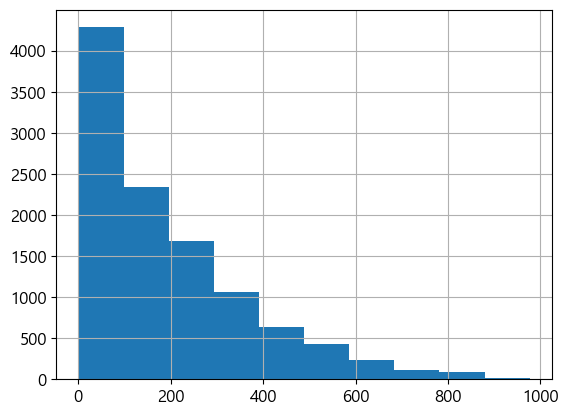

In [104]:
## 분포 확인 
y_target.hist()
# 차이가 많이 난다면 로그 변환을 해보자.

<Axes: >

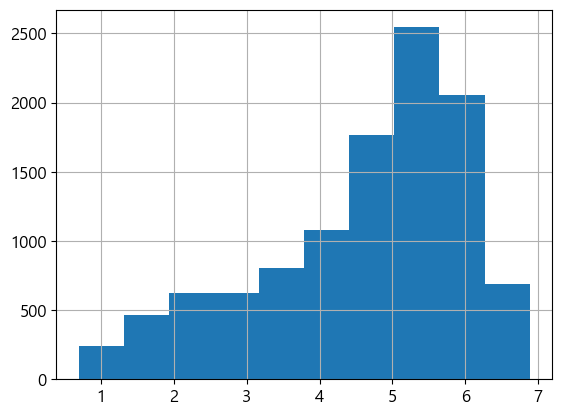

In [105]:
# 타겟의 로그 변환
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [108]:
y_target_log=np.log1p(y_target)
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target_log,
                                              test_size=0.3,random_state=42)
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
# target은 로그변환된 상태이다.
# 원래의 값으로 되돌려야 하는 것을 절대 잊지말자
pred=lr_reg.predict(X_test)
y_test_exp=np.expm1(y_test)
pred_exp=np.expm1(pred)
evaluate_regr(y_test_exp,pred_exp)
# 로그변환 전
# RMSLE:1.173545002937317,RMSE:141.26170349121094,MAE:19954.869140625 

RMSLE:1.0202172994613647,RMSE:160.72909545898438,MAE:25833.84375


## Feature 인코딩 & 회귀계수 확인

<Axes: >

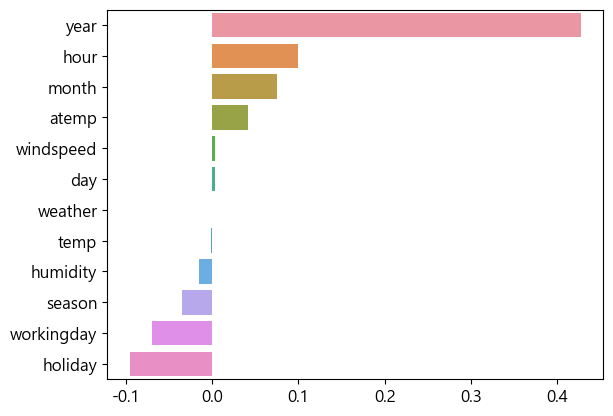

In [109]:
# 회귀계수를 먼저 확인하자
coef=pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
import seaborn as sns
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [110]:
# 원핫인코딩
X_feature_ohe=pd.get_dummies(X_features,columns=['year','month',
                                                'day', 'hour',
                                                'holiday','workingday',
                                                'season','weather'])
X_feature_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [111]:
X_train,X_test,y_train,y_test=train_test_split(X_feature_ohe, 
                                               y_target_log,
                                              test_size=0.3,
                                               random_state=42)

In [112]:
# 모델과 데이터를 받아서 훈련하고 평가지표를 출력하는 함수
# 로그까지 생각해
def get_model_predict(model, X_train,X_test,y_train,y_test,is_expm1=False):
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print(model.__class__.__name__)
    evaluate_regr(y_test,pred)

In [114]:
lr_reg=LinearRegression()
get_model_predict(lr_reg, X_train,X_test,y_train,y_test,is_expm1=True)

LinearRegression
RMSLE:0.5870844721794128,RMSE:98.02251434326172,MAE:9608.4130859375


## 규제 모델을 이용한 훈련

In [122]:
# 일반적으로 규제 모델을 사용하면
# 선형회귀보다는 성능이 좋아질 가능성이 높습니다.
from sklearn.linear_model import Ridge, Lasso
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.001)
get_model_predict(ridge_reg,X_train,X_test,y_train,y_test, is_expm1=True)
get_model_predict(lasso_reg,X_train,X_test,y_train,y_test, is_expm1=True)

Ridge
RMSLE:0.5866859555244446,RMSE:96.82743835449219,MAE:62.888954162597656
Lasso
RMSLE:0.5856897830963135,RMSE:96.6834716796875,MAE:62.52202606201172


## 트리 모델도 해보자

In [121]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
rf_reg=RandomForestRegressor(n_estimators=500)
gbm_reg=GradientBoostingRegressor(n_estimators=500)
xgb_reg=XGBRegressor(n_estimators=500)
# xgboost는 dataframe을 주면 오류가 생기는 경우가 있습니다.
# 그러면 data들을 X_train.values 로 해서 ndarray로 바꿔주자. 4개다
for model in [rf_reg,gbm_reg, xgb_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=True)

RandomForestRegressor
RMSLE:0.3494306723702703,RMSE:48.05848648298074,MAE:30.0561243219015
GradientBoostingRegressor
RMSLE:0.3313329696523006,RMSE:51.70155748441125,MAE:32.18487076548191
XGBRegressor
RMSLE:0.343942791223526,RMSE:50.52873611450195,MAE:31.14518928527832


<br>

# 군집

In [123]:
import sys

# 사이킷런 ≥0.20 필수
import sklearn

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

## 샘플 데이터를 이용한 군집

In [127]:
from sklearn.datasets import make_blobs
# 200ro 데이터 생성 피처 2개
# 중심 3개 표준편차 0.8
X,y=make_blobs(n_samples=200,n_features=2,centers=3,cluster_std=0.8,
               random_state=42)
print(X.shape,y.shape)

(200, 2) (200,)


In [128]:
unique,counts=np.unique(y,return_counts=True)
print(unique)
print(counts)

[0 1 2]
[67 67 66]


In [129]:
# 해석을 편하게 하기 위해 DataFrame화 시키자
clusterDF=pd.DataFrame(data=X,columns=['ftr1','ftr2'])
clusterDF['target']=y
clusterDF.head()

,ftr1,ftr2,target
0,6.132,2.352,1
1,-4.605,9.672,0
2,-6.889,-7.598,2
3,-8.038,-8.006,2
4,-7.351,-6.200,2


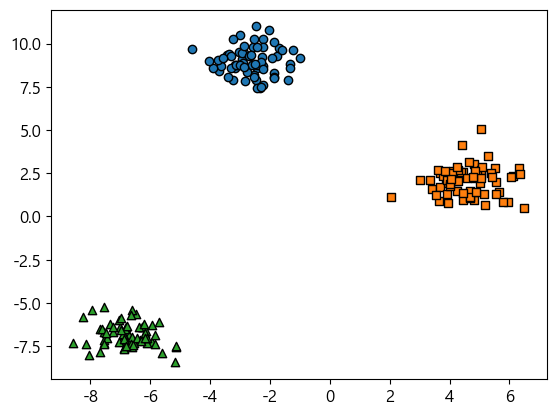

In [132]:
# 데이터 분포 확인
target_list=np.unique(y)
markers=['o','s','^','P','D','H','x']
for target in target_list:
    target_cluster=clusterDF[clusterDF['target']==target]
    plt.scatter(x=target_cluster['ftr1'],y=target_cluster['ftr2'], 
               edgecolor='k', marker=markers[target])

In [135]:
from sklearn.mixture import GaussianMixture
y_pred=GaussianMixture(n_components=3,random_state=42).fit(X).predict(X)
print(y_pred)
print(y)

[2 0 1 1 1 1 0 1 2 1 2 2 2 2 2 1 0 1 2 1 2 2 1 0 1 0 0 1 0 2 2 2 1 1 0 0 1
 0 1 0 2 0 1 2 1 2 2 1 2 0 1 0 1 0 0 0 1 2 0 2 1 0 1 1 1 1 0 0 1 0 0 1 0 2
 0 2 2 0 2 0 0 2 2 1 1 1 1 0 2 1 2 0 0 0 2 1 0 2 2 0 1 1 0 1 0 2 1 2 2 1 2
 2 0 1 0 1 1 0 0 0 1 2 0 1 1 2 0 0 2 0 2 1 0 1 1 2 2 2 0 2 0 0 1 2 2 0 2 1
 1 2 0 1 2 1 2 1 1 0 2 2 0 2 2 1 0 2 2 0 1 2 1 0 2 1 0 2 0 0 0 2 0 2 1 1 1
 0 2 2 2 0 0 2 1 1 0 1 0 0 2 2]
[1 0 2 2 2 2 0 2 1 2 1 1 1 1 1 2 0 2 1 2 1 1 2 0 2 0 0 2 0 1 1 1 2 2 0 0 2
 0 2 0 1 0 2 1 2 1 1 2 1 0 2 0 2 0 0 0 2 1 0 1 2 0 2 2 2 2 0 0 2 0 0 2 0 1
 0 1 1 0 1 0 0 1 1 2 2 2 2 0 1 2 1 0 0 0 1 2 0 1 1 0 2 2 0 2 0 1 2 1 1 2 1
 1 0 2 0 2 2 0 0 0 2 1 0 2 2 1 0 0 1 0 1 2 0 2 2 1 1 1 0 1 0 0 2 1 1 0 1 2
 2 1 0 2 1 2 1 2 2 0 1 1 0 1 1 2 0 1 1 0 2 1 2 0 1 2 0 1 0 0 0 1 0 1 2 2 2
 0 1 1 1 0 0 1 2 2 0 2 0 0 1 1]


In [137]:
# 매핑된 격허ㅣ
from scipy import stats
mapping={}
for class_id in np.unique(y):
    mode, _=stats.mode(y_pred[y==class_id])
    mapping[mode[0]]=class_id
print(mapping)

{0: 0, 2: 1, 1: 2}


# 과일 이미지 군집

In [138]:
# 데이터 가져오기
fruits=np.load('./data/fruits_300.npy')
# 데이터 300개이고 이미지는 100*100 grayscale
print(fruits.shape)

(300, 100, 100)


In [139]:
# 세로 픽셀을 출력하니 0~255 사이 숫자
print(fruits[0,0,:])

[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1
   2   2   2   2   2   2   1   1   1   1   1   1   1   1   2   3   2   1
   2   1   1   1   1   2   1   3   2   1   3   1   4   1   2   5   5   5
  19 148 192 117  28   1   1   2   1   4   1   1   3   1   1   1   1   1
   2   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]


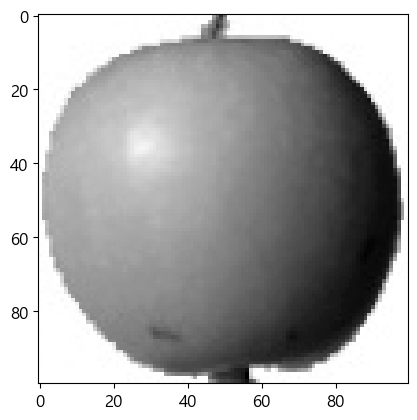

In [143]:
# 이미지 출력
# 관심을 갖는 것은 물체이기에 
# 물체 이외는 흰색으로 보여지는게 더 나을 수 있음
plt.imshow(fruits[1], cmap='gray_r')
plt.show()

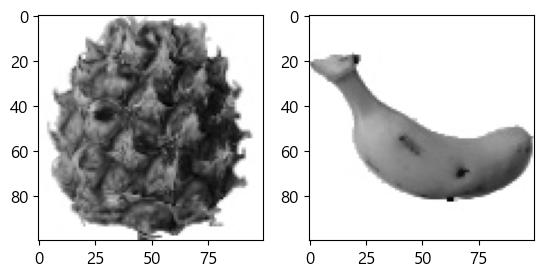

In [148]:
# 파인애플과 바나나
fig,axs=plt.subplots(1,2)
axs[0].imshow(fruits[180],cmap='gray_r')
axs[1].imshow(fruits[230],cmap='gray_r')
plt.show()

In [151]:
# 이미지 데이터를 비교하기 위해서는 1차원으로 변경해야 합니다.
# 방법 1 - reshape
# 얘는 배열안에 배열로 
print(fruits[0].reshape(-1,100*100))
print(fruits[0].reshape(-1,100*100).shape)
# 방법 2 - flatten
# 얘는 단순 배열로
print(fruits[0].flatten())
print(fruits[0].flatten().shape)

[[1 1 1 ... 1 1 1]]
(1, 10000)
[1 1 1 ... 1 1 1]
(10000,)


In [153]:
# 이미지를 reshape로 1차원으로 쭉 바꾸자
apple=fruits[0:100].reshape(-1,100*100)
pineapple=fruits[100:200].reshape(-1,100*100)
banana=fruits[200:300].reshape(-1,100*100)
print(apple.shape)

(100, 10000)


In [155]:
# 이미지들의 평균을 출력해보자.
# 이미지들끼리 비슷비슷하다
print(apple.mean(axis=1))
print(pineapple.mean(axis=1))
print(banana.mean(axis=1))

[ 88.335  97.925  87.371  98.37   92.871  82.644  94.424  95.6    90.681
  81.623  87.058  95.075  93.842  87.017  97.508  87.202  88.983 100.916
  92.782 100.918 104.985  88.674  99.564  97.249  94.118  92.194  95.167
  93.332 102.897  94.669  90.528  89.074  97.764  97.294 100.756  90.524
 100.254  85.845  96.462  97.149  90.711 102.319  87.163  89.875  86.733
  86.399  95.287  89.171  96.816  91.66   96.106  99.683  94.972  87.481
  89.26   89.527  93.799  97.398  87.151  97.825 103.22   94.424  83.666
  83.516 102.845  87.038  91.274 100.485  93.839  90.857  97.462  97.502
  82.446  87.179  96.921  90.314  90.565  97.654  98.092  93.625  87.387
  84.707  89.114  86.765  88.73   86.643  96.732  97.26   81.942  87.169
  97.207  83.471  95.978  91.81   98.409 100.782 101.556 100.703  91.61
  88.898]
[ 99.324  87.162  97.193  97.469  98.889  97.882  95.144  92.946  95.841
  96.949  93.286 101.277  91.651  98.39   84.328 100.702  99.023  87.53
  99.411  91.857  90.388  99.507  95.85   9

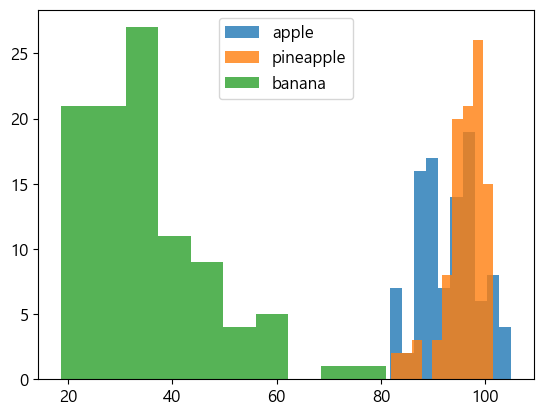

In [157]:
# 평균을 시각화
plt.hist(np.mean(apple,axis=1),alpha=0.8)
plt.hist(np.mean(pineapple,axis=1),alpha=0.8)
plt.hist(np.mean(banana,axis=1),alpha=0.8)
plt.legend(['apple','pineapple','banana'])
plt.show()

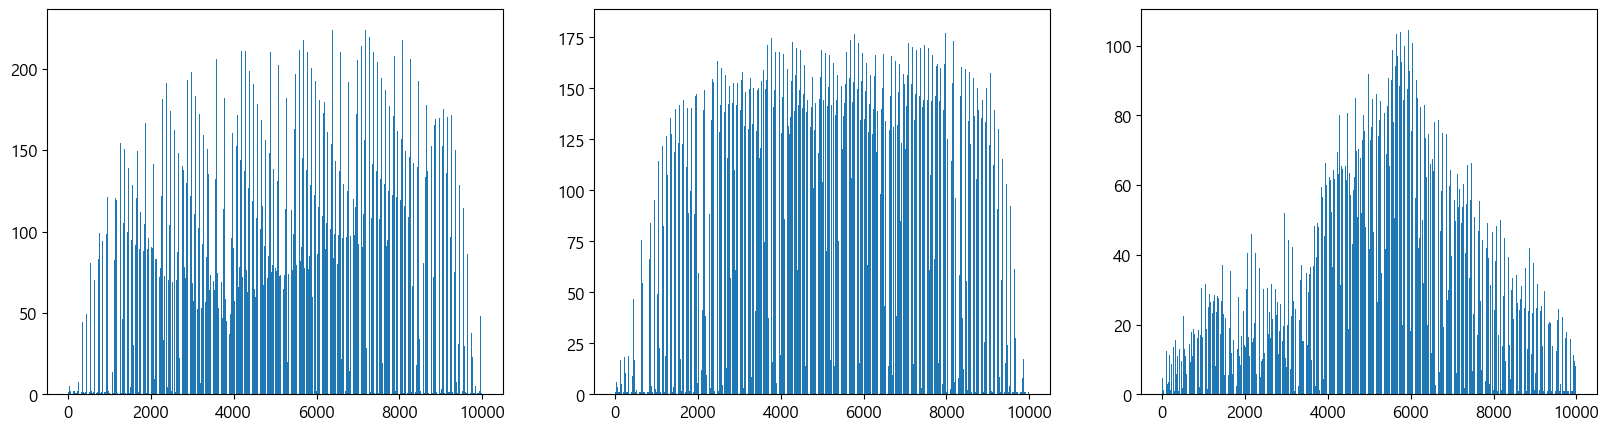

In [158]:
# 픽셀 단위로 평균을 찍어보자.
fig,axs=plt.subplots(1,3,figsize=(20,5))
axs[0].bar(range(10000),np.mean(apple,axis=0))
axs[1].bar(range(10000),np.mean(pineapple,axis=0))
axs[2].bar(range(10000),np.mean(banana,axis=0))
plt.show()

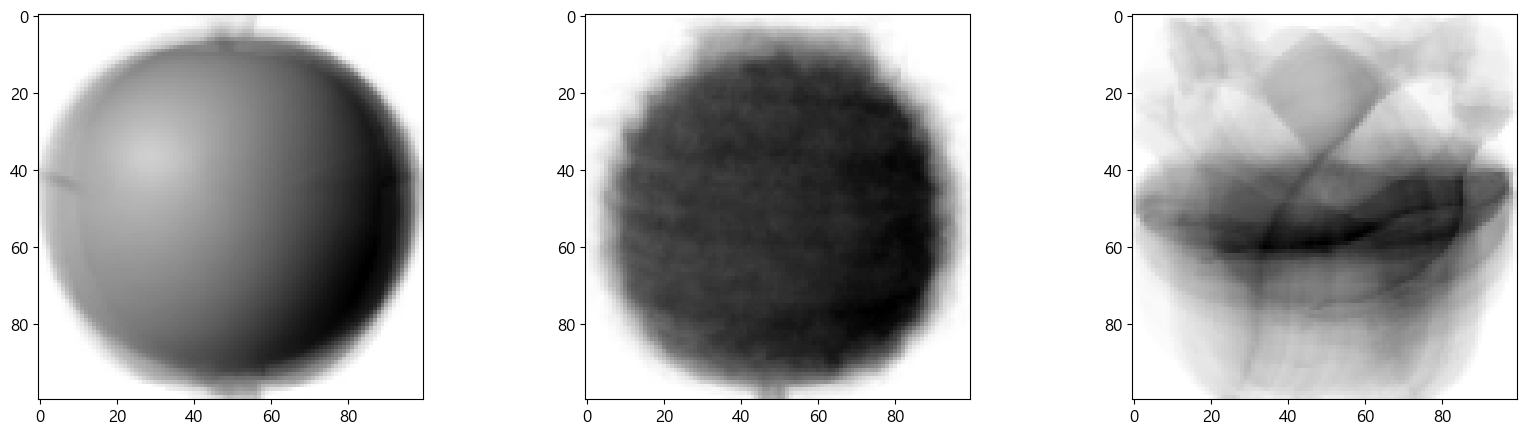

In [160]:
# 평균을 가지고 이미지 생성
apple_mean=np.mean(apple,axis=0).reshape(100,100)
pineapple_mean=np.mean(pineapple,axis=0).reshape(100,100)
banana_mean=np.mean(banana,axis=0).reshape(100,100)
fig,axs=plt.subplots(1,3,figsize=(20,5))
axs[0].imshow(apple_mean, cmap='gray_r')
axs[1].imshow(pineapple_mean, cmap='gray_r')
axs[2].imshow(banana_mean, cmap='gray_r')
plt.show()

In [162]:
# 모든 데이터에서 사과의 평균을 뺀 절대값 구하기
abs_diff=np.abs(fruits-apple_mean)
abs_mean=np.mean(abs_diff,axis=(1,2))
print(abs_mean.shape)

(300,)


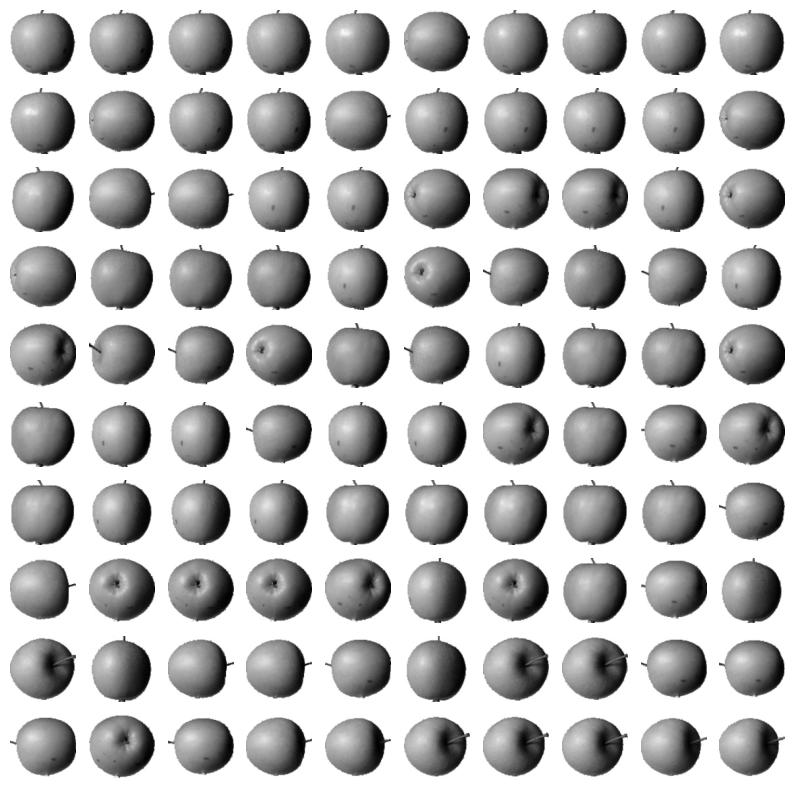

In [164]:
# 평균을 뺀 절대값이 가장 작은 것 100개를 출력
apple_index=np.argsort(abs_mean)[:100]
fig,axs=plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(fruits[apple_index[i*10+j]], cmap='gray_r')
        axs[i,j].axis('off')
plt.show()
# 대부분은 사과입니다.

## K-Means 알고리즘

### 임의의 샘플 데이터를 이용한 군집

In [4]:
from sklearn.datasets import make_blobs

#중심점의 좌표 와 표준 편차 생성
blob_centers = np.array([[0.2, 2.3], [-1.5, 2.3], 
                         [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

#데이터 생성
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                 random_state=42)

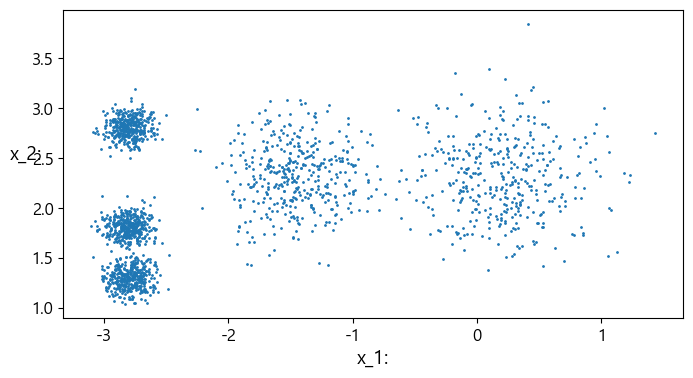

In [5]:
#데이터 확인
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("x_1:", fontsize=14)
    plt.ylabel("x_2:", fontsize=14, rotation=0)
    
plt.figure(figsize=(8,4))
plot_clusters(X)
plt.show()

In [6]:
#군집 수행
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
print(y_pred)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


[2 1 3 ... 1 2 4]


In [7]:
# 각 그룹의 중앙점의 좌표 출력
print(kmeans.cluster_centers_)

[[-2.792  1.297]
 [ 0.209  2.304]
 [-2.798  2.8  ]
 [-1.445  2.321]
 [-2.804  1.809]]


In [8]:
#예측
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
print(kmeans.predict(X_new))

[1 1 2 2]


C:\Users\USER\AppData\Local\Temp\ipykernel_1572\3890473721.py:32: UserWarning: linewidths is ignored by contourf
  plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,
C:\Users\USER\AppData\Local\Temp\ipykernel_1572\3890473721.py:32: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,


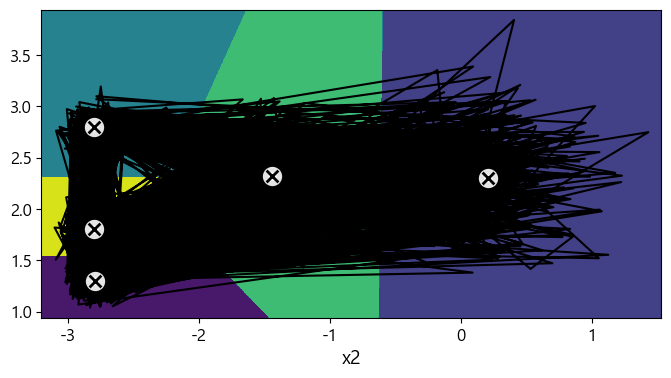

In [9]:
# 결정 경계를 시각화
#voronoi diagram: 평면을 특정 점까지의 거리가 가까운 점의 집합으로 분할한 그림

#데이터의 분포를 시각화
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k', markersize=2)
    
    
#중심점을 출력하는 함수
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=35,
               linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2,
               linewidths=12, color=cross_color, zorder=11, alpha=1.0)
    
#결정 경계를 그려주는 함수
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                        np.linspace(mins[1], maxs[1], resolution))
    
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap='Pastel2')
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, 
                color='k')
    plot_data(X)
    
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    
    if show_xlabels:
        plt.xlabel("x1", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    
    if show_ylabels:
        plt.xlabel("x2", fontsize=14)
    else:
        plt.tick_params(labelleft=False)
        

#결정 경계를 그려주는 함수를 호출
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [10]:
#중심점 과 의 거리 확인
print(kmeans.transform(X_new))
print(kmeans.predict(X_new))

[[2.879 0.369 2.911 1.48  2.81 ]
 [5.835 2.807 5.853 4.457 5.807]
 [1.715 3.284 0.284 1.697 1.207]
 [1.22  3.215 0.361 1.565 0.719]]
[1 1 2 2]


In [11]:
#유클리드 거리 확인
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_,
               axis=2)

array([[2.879, 0.369, 2.911, 1.48 , 2.81 ],
       [5.835, 2.807, 5.853, 4.457, 5.807],
       [1.715, 3.284, 0.284, 1.697, 1.207],
       [1.22 , 3.215, 0.361, 1.565, 0.719]])

In [12]:
#평가 지표 출력
print(kmeans.inertia_)
print(kmeans.score(X))

213.4217713125891
-213.4217713125891


In [13]:
%%time
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
print(kmeans.inertia_)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


213.42177131258913
CPU times: total: 2.19 s
Wall time: 254 ms


In [14]:
%%time
from sklearn.cluster import MiniBatchKMeans
k = 5
miniBatchKMeans = MiniBatchKMeans(n_clusters=k, random_state=42)
y_pred = miniBatchKMeans.fit_predict(X)
print(miniBatchKMeans.inertia_)

213.57214964975
CPU times: total: 984 ms
Wall time: 136 ms


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [15]:
#이너셔를 이용한 최적의 클러스터 개수 찾기
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
print(inertias)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

[3535.902973409424, 1169.7223309938965, 662.9432340781607, 265.8740271685503, 213.42177131258913, 173.41021888733104, 146.70624728469895, 122.21669990809283, 107.07177911806438]


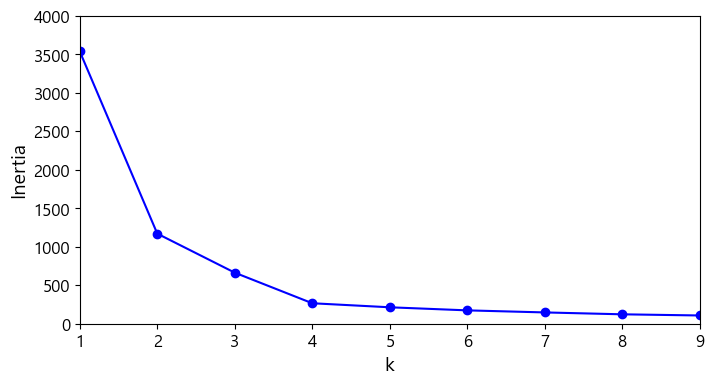

In [16]:
#elbow를 찾기 위해서 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 9, 0, 4000])
plt.show()

In [17]:
from sklearn.metrics import silhouette_score
print(silhouette_score(X, kmeans.labels_))

0.656578194104489


[0.5888699625637426, 0.5690585495403864, 0.6848978374857873, 0.656578194104489, 0.6038071457653064, 0.5564756994071687, 0.5607889470176775, 0.5635438960242384]


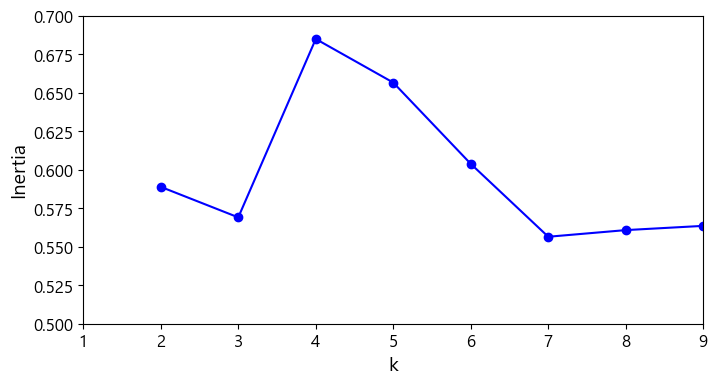

In [18]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
print(silhouette_scores)
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 9, 0.5, 0.7])
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_1572\3630620879.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')


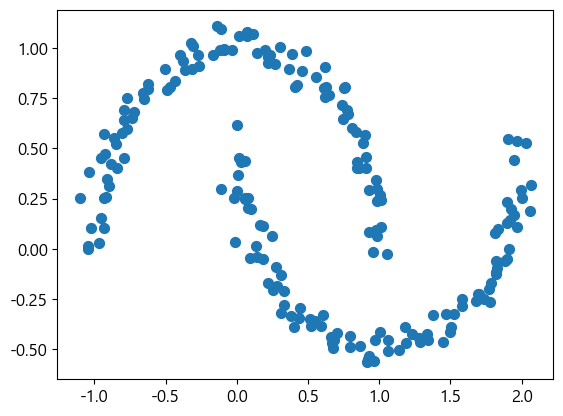

In [19]:
##k-means 의 한계

#완전한 원형이 아닌 데이터 생성
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=0.05, random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


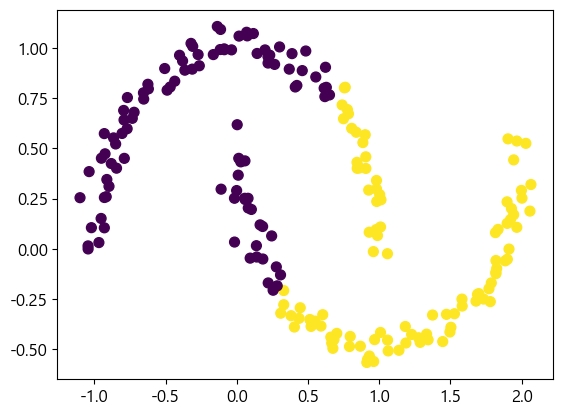

In [20]:
labels = KMeans(2, random_state=42).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

(533, 800, 3)


(-0.500, 799.500, 532.500, -0.500)

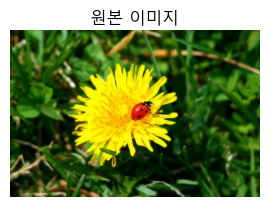

In [21]:
# 군집을 이용한 이미지 분할
#이미지를 읽어와서 출력하기
from matplotlib.image import imread
image = imread('./data/ladybug.png')
print(image.shape)
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.subplot(231)
plt.imshow(image)
plt.title("원본 이미지")
plt.axis('off')

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


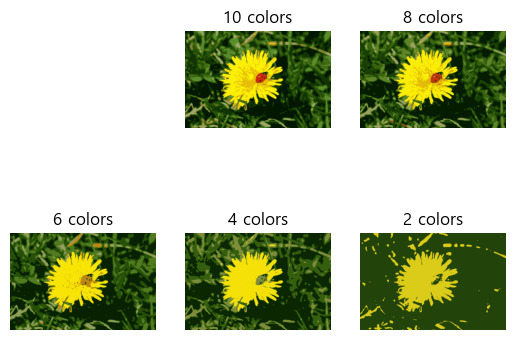

In [22]:
#색상을 가지고 군집을 수행
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
#각 픽셀이 속한 클러스터의 중앙 좌표를 저장
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
#print(segmented_img)
segmented_imgs = []
n_colors = [10, 8, 6, 4, 2]
for n_clusters in n_colors:
    print(n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))
for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{0} colors".format(n_clusters))
    plt.axis('off')
plt.show()

In [23]:
#군집을 이용한 차원 축소 후 분류
#8 * 8 크기의 흑백 숫자 이미지 1797 개 가져오기
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
print(X_digits.shape)
print(y_digits.shape)

(1797, 64)
(1797,)


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits,
                                                   random_state=42)
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', 
                             max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [25]:
log_reg_score = log_reg.score(X_test, y_test)
print(log_reg_score)

0.9688888888888889


In [26]:
from sklearn.pipeline import Pipeline
#군집한 클러스터를 속성으로 추가해서 분류를 하기 때문에 성능이 좋아질 가능성이 높음
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs",
                                  max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)
pipeline_score = pipeline.score(X_test, y_test)
print(pipeline_score)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


0.9777777777777777


In [27]:
%%time
#최적의 클러스터 개수 찾기
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=6; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=6; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=6; total time=   0.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=7; total time=   0.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=7; total time=   0.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=7; total time=   0.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=9; total time=   0.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=9; total time=   0.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=9; total time=   0.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   0.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   0.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   0.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   0.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   1.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   0.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   1.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   1.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   1.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   1.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   1.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   1.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   1.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   1.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   1.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   1.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   1.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   1.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   2.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   2.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   2.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   2.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   2.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   2.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   2.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   2.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   2.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   2.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   2.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   2.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   2.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   2.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   2.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   3.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   2.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   2.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   3.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   3.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   3.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   4.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   4.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   4.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   4.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=35; total time=   3.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=35; total time=   3.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=35; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=36; total time=   4.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=36; total time=   4.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=36; total time=   3.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=37; total time=   4.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=37; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=37; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=38; total time=   4.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=38; total time=   4.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=38; total time=   4.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=39; total time=   4.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=39; total time=   4.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=39; total time=   4.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=40; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=40; total time=   4.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=40; total time=   4.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=41; total time=   2.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=41; total time=   2.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=41; total time=   2.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=43; total time=   2.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=43; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=43; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=44; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=44; total time=   2.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=44; total time=   2.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=45; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=45; total time=   2.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=45; total time=   2.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=46; total time=   2.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=46; total time=   2.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=46; total time=   2.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=47; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=47; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=47; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=48; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=48; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=48; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=49; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=49; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=49; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=50; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=50; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=50; total time=   3.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=51; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=51; total time=   3.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=51; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   3.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=53; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=53; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=53; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=54; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=54; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=54; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=55; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=55; total time=   3.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=55; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=56; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=56; total time=   3.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=56; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=57; total time=   2.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=57; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=57; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=58; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=58; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=58; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=59; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=59; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=59; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=60; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=60; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=60; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=61; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=61; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=61; total time=   3.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=63; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=63; total time=   4.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=63; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=64; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=64; total time=   4.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=64; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=65; total time=   3.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=65; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=65; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=66; total time=   4.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=66; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=66; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=67; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=67; total time=   3.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=67; total time=   3.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=68; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=68; total time=   3.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=68; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=69; total time=   3.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=69; total time=   3.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=69; total time=   3.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=70; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=70; total time=   6.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=70; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=71; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=71; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=71; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   6.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   5.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=73; total time=   5.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=73; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=73; total time=   4.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=74; total time=   5.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=74; total time=   5.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=74; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=75; total time=   5.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=75; total time=   6.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=75; total time=   5.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=76; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=76; total time=   5.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=76; total time=   4.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=77; total time=   5.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=77; total time=   6.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=77; total time=   5.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=78; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=78; total time=   5.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=78; total time=   6.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=79; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=79; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=79; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=80; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=80; total time=   5.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=80; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=81; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=81; total time=   5.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=81; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=83; total time=   5.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=83; total time=   5.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=83; total time=   5.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=84; total time=   5.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=84; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=84; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=85; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=85; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=85; total time=   5.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=86; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=86; total time=   5.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=86; total time=   4.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=87; total time=   5.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=87; total time=   6.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=87; total time=   6.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=88; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=88; total time=   6.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=88; total time=   5.8s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=89; total time=   6.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=89; total time=   5.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=89; total time=   5.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=90; total time=   4.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=90; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=90; total time=   4.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=91; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=91; total time=   5.7s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=91; total time=   6.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   4.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   5.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   5.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   4.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   7.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   5.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   5.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   5.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   5.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   5.9s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   5.2s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   6.1s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   5.6s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   6.0s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   5.5s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   6.4s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   5.3s


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


CPU times: total: 42min 39s
Wall time: 18min 10s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [ ]:
print(grid_clf.best_params_)
print(grid_clf.score(X_test, y_test))

## 계층적 군집

In [ ]:
#병합 군집
np.random.seed(42)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID4']
X = np.random.random_sample([5, 3]) * 10 
df = pd.DataFrame(X, columns=variables, index=labels)
print(df)

In [ ]:
#거리 계산
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')), columns=labels,
                       index=labels)
print(row_dist)

In [ ]:
#계층적 클러스터링
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete')
pd.DataFrame(row_clusters, columns=['row label 1', 'row label 2', 'distance', 
                                   'items in cluster'],
            index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
#첫번째 와 두번째는 병합된 클러스터 이름이고 세번째는 거리고 네번째는 아이템 개수
#처음에는 클러스터가 데이터 개수만큼이므로 5개
#1번 클러스터 와 4번 클러스터를 합쳐서 5번 클러스터 생성(데이터 2개)
#0번 클러스터 와 2번 클러스터를 합쳐서 6번 클러스터 생성(데이터 2개)
#3번 클러스터 와 5번 클러스터를 합쳐서 7번 클러스터 생성(데이터 3개)
#6번 클러스터 와 7번 클러스터를 합쳐서 8번 클러스터 생성(데이터 5개)

In [ ]:
#덴드로그램 출력
#계층적 군집을 시각화 하는 도구
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters, labels=labels)
plt.show()

In [ ]:
## Gaussian Mixture Model

In [ ]:
#샘플 데이터를 3개의 군집으로 묶기
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=42)
gm.fit(X)

In [ ]:
#중심점의 좌표
print(gm.means_)

In [ ]:
#예측
print(gm.predict(X))

In [ ]:
#확률
print(gm.predict_proba(X))

In [ ]:
#생성
X_new, y_new = gm.sample(6)
print(X_new)
print(y_new)